# Libraries

In [1]:
import joblib

import pandas 			 as pd
import numpy 			 as np
import matplotlib.pyplot as plt

import scipy.signal 	 as signal
import scipy.stats 		 as stats

from sklearn.metrics import mean_squared_error

# ECG Definitions

ECG file headers

In [2]:
ecgHeaders = [
	"sample",
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

Loading ECGs labeled as acceptable

In [3]:
ecgsDataset = []

with open("../../../data/labels/RECORDS-acceptable") as file:
	ecgsDataset = map(
		lambda ecgName: ecgName.strip(), 
		file.readlines()
	)
	ecgsDataset = list(ecgsDataset) 

	print("Dataset len =", len(ecgsDataset))

Dataset len = 773


ECG preprocessing function

- highpass butterworth filter with $ f_c = 1$ Hz
- Truncation in the tails of $N = 500$ samples

In [4]:
order = 2
fc = 1
fs = 500

b, a = signal.butter(
	N = order,
	Wn = fc,
	btype = "highpass",
	fs = fs
)

print("Numerator: ",   b)
print("Denominator: ", a)

Numerator:  [ 0.9911536  -1.98230719  0.9911536 ]
Denominator:  [ 1.         -1.98222893  0.98238545]


In [5]:
def preprocessing(ecgDf):
	ecgFiltred = ecgDf.apply(
		lambda serie: 2.5 * signal.filtfilt(b, a, serie), 
		axis = 0
	)
	ecgCroped = ecgFiltred.iloc[500: -500]

	return ecgCroped

# Linear Regression Definitions

Features Vector

In [6]:
ecgFeatures = [
	"LI", 
	"aVF", 
	"V2"
]

Target Vector

In [7]:
ecgTarget = [
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"V1",
	"V3",
	"V4",
	"V5",
	"V6"
]

Loading Linear Regression Model and Scaler

In [8]:
linearRegression = joblib.load("../../../models/t0/reglin-t0-v0.pkl")

print(linearRegression.coef_)
print(linearRegression.intercept_)

[[ 2.90573513e+02 -2.57577108e+02 -1.06573805e-01]
 [ 1.44064940e+02 -2.57577108e+02 -1.06573805e-01]
 [-2.17406064e+02  1.28044151e+02  1.06753913e-01]
 [ 2.16614070e+02 -2.57364358e+02 -1.56607594e-01]
 [-1.40991589e+02  5.44422301e+01  8.63191363e+01]
 [ 1.32361752e+02 -1.50172495e+02  1.12635454e+02]
 [ 2.73036648e+02 -2.29196928e+02  5.81749060e+01]
 [ 2.80053334e+02 -2.10383838e+02  1.85173977e+01]
 [ 2.38808941e+02 -1.70123563e+02 -4.58139588e+00]]
[-0.06564727 -0.13816772 -0.00433837 -0.10139449 -0.2906584   0.73920721
 -0.14549983 -0.05890454  0.64685504]


In [9]:
scaler = joblib.load("../../../models/t0/reglin-t0-v0.scaler.pkl")

print(scaler.mean_)
print(scaler.var_)

[ 0.07252045  0.10653853 -0.82566417]
[ 21464.76185011  16852.82942475 151122.52147805]


# Graphical analysis of reconstruction performance

Calculating Pearson Correlations and Root Mean Square Error for each ECG

In [10]:
correlations = pd.DataFrame(columns = ecgTarget)
mseScores 	 = pd.DataFrame(columns = ecgTarget)

for ecgID in ecgsDataset:
	
	# Load and clean ECG file

	ecg      = pd.read_csv(
		filepath_or_buffer = f"../../../data/set-a/{ecgID}.txt",
		names              = ecgHeaders,
		index_col 		   = 0
	)

	ecgClean = preprocessing(ecg)


	# Extract features and expected vector

	features   = ecgClean[ecgFeatures].values
	expected   = ecgClean[ecgTarget]

	
	# Reconstructing the derivations
	
	predicted  = linearRegression.predict(
		X = scaler.transform(
			X = features
		)
	)
	predicted  = pd.DataFrame(
		data    = predicted,
		columns = ecgTarget,
	)


	# Calculating MSE and CORR for each lead

	mseRow  = pd.DataFrame(columns = ecgTarget)
	corrRow = pd.DataFrame(columns = ecgTarget)

	for derivation in ecgTarget:
		
		mseRow[derivation]  = [mean_squared_error(
			y_true = expected[derivation],
			y_pred = predicted[derivation]
		)]

		corrRow[derivation] = [stats.pearsonr(
			x = expected[derivation],
			y = predicted[derivation]
		).statistic]


	# Storing the metrics

	mseScores 	 = pd.concat(
		[mseScores, mseRow], 
		ignore_index = True
	)
	correlations = pd.concat(
		[correlations, corrRow],  
		ignore_index = True
	)


/tmp/ipykernel_18306/2814319763.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mseScores 	 = pd.concat(
/tmp/ipykernel_18306/2814319763.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlations = pd.concat(
/tmp/ipykernel_18306/2814319763.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corrRow[derivation] = [stats.pearsonr(
/tmp/ipykernel_18306/2814319763.py:48: ConstantInputWarning: An input array is constant; the correlation 

Description of statistical measures

In [11]:
correlations = correlations.dropna()
correlations.describe()

,LII,LIII,aVR,aVL,V1,V3,V4,V5,V6
count,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000
mean,0.999533,0.999244,0.999664,0.998804,0.803377,0.737976,0.723285,0.776723,0.810650
std,0.000758,0.000888,0.000436,0.001205,0.281470,0.296545,0.302586,0.307277,0.299370
min,0.983257,0.992808,0.992772,0.991278,-0.929338,-0.718723,-0.900501,-0.918748,-0.918303
25%,0.999453,0.998983,0.999613,0.998368,0.791342,0.660693,0.644686,0.751599,0.820066
50%,0.999672,0.999556,0.999762,0.999218,0.909159,0.857616,0.843627,0.896233,0.923989
75%,0.999810,0.999796,0.999846,0.999640,0.957306,0.930715,0.923041,0.949428,0.963256
max,0.999992,0.999994,0.999984,0.999988,0.996758,0.997335,0.992351,0.991671,0.992289


In [12]:
mseScores = mseScores.dropna()
mseScores.describe()

,LII,LIII,aVR,aVL,V1,V3,V4,V5,V6
count,773.000000,773.000000,773.000000,773.000000,7.730000e+02,7.730000e+02,7.730000e+02,7.730000e+02,7.730000e+02
mean,2.086781,2.086781,1.374519,2.842589,2.061160e+05,1.346906e+05,1.284721e+05,3.598038e+04,1.016061e+05
std,0.358358,0.358358,0.273493,0.525347,4.530212e+06,2.743448e+06,2.249419e+06,4.256525e+05,2.031454e+06
min,1.079298,1.079298,0.899589,1.626307,4.699444e+01,9.927494e+01,1.677059e+02,1.021925e+02,8.252960e+01
25%,1.921628,1.921628,1.244594,2.582981,4.568398e+02,2.068216e+03,1.401730e+03,8.194174e+02,4.402952e+02
50%,2.070979,2.070979,1.356608,2.804710,1.047950e+03,4.164248e+03,3.046371e+03,1.765491e+03,9.459994e+02
75%,2.210052,2.210052,1.466521,3.028839,2.680055e+03,9.313566e+03,7.106583e+03,4.256172e+03,2.381974e+03
max,7.655084,7.655084,5.870739,10.356578,1.242576e+08,7.367890e+07,5.543284e+07,8.868013e+06,5.552952e+07


The comparative plot function

In [13]:
def methodComparativePlot(df, derivation, method):
	dfMean = np.mean(df[derivation])
	dfMean = np.round(dfMean, 3)

	figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

	axes[0].set_title(f"{method}($ {derivation} $, $ {derivation}_{{rec}} $)")
	axes[1].set_title(f"Histograma - {method}($ {derivation} $, $ {derivation}_{{rec}} $)")

	axes[0].set_xlabel("n")
	axes[0].set_ylabel(f"{method}")
	
	axes[1].set_xlabel(f"{method}")
	axes[1].set_ylabel("Frequência")


	axes[0].scatter(
		df.index, 
		df[derivation]
	)
	axes[0].axhline(
		dfMean, 
		color     = 'r', 
		linestyle = '--', 
		label     = f"Média = {dfMean}"
	)


	counts, bins = np.histogram(df[derivation], 50)
	axes[1].stairs(counts / len(df[derivation]), bins, fill = True)
	axes[1].axvline(
		dfMean, 
		color     = 'r', 
		linestyle = '--', 
		label     = f"Média = {dfMean}"
	)

	axes[1].legend()
	axes[0].legend()

	plt.show()

	plt.close()

## Results

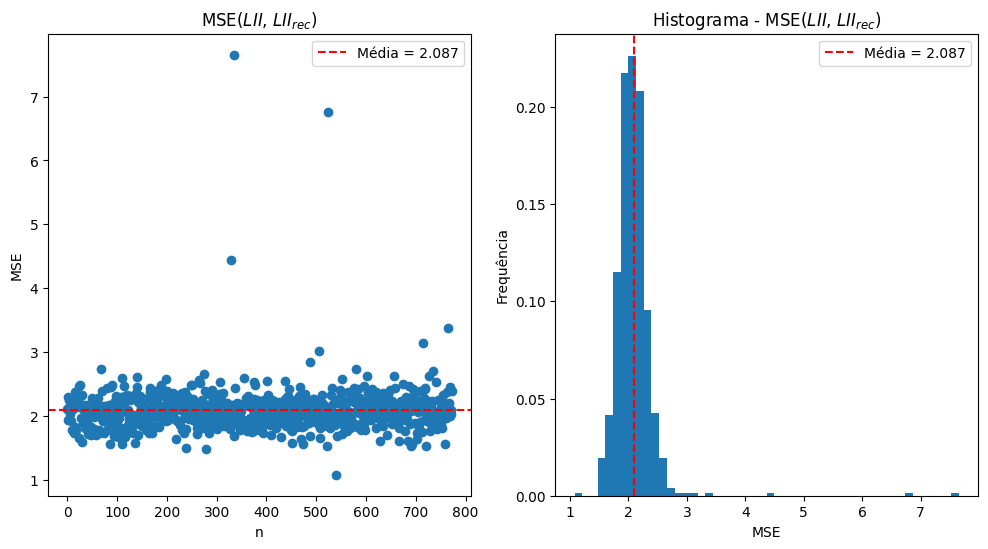

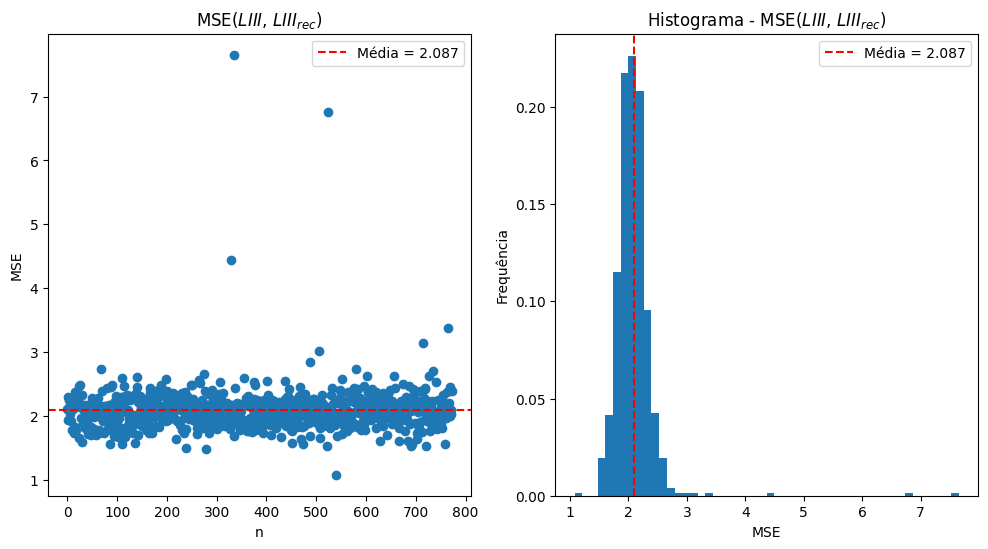

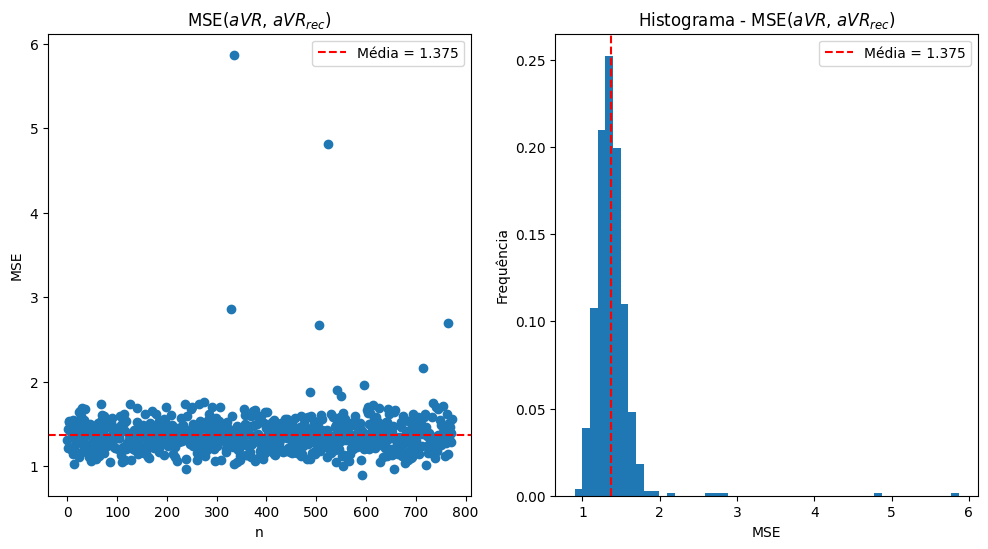

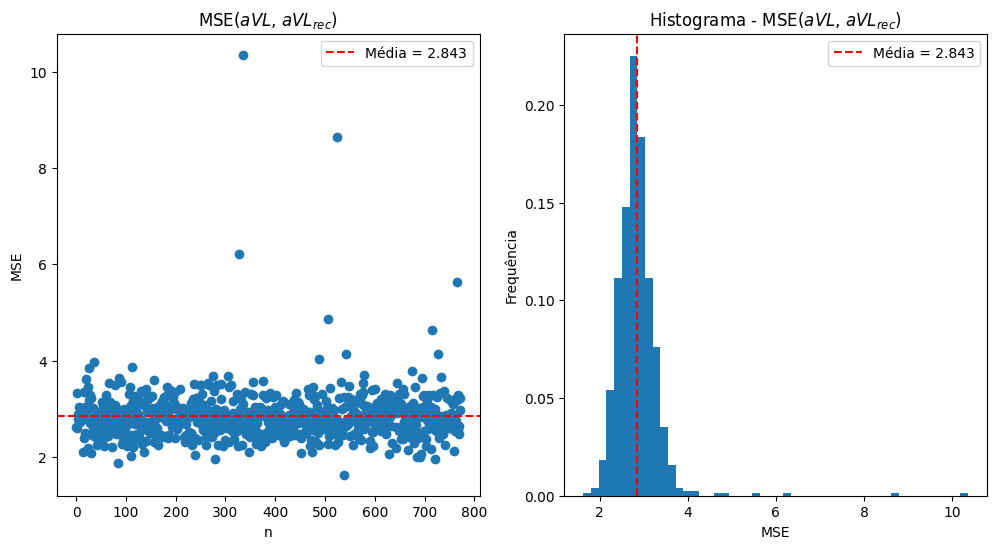

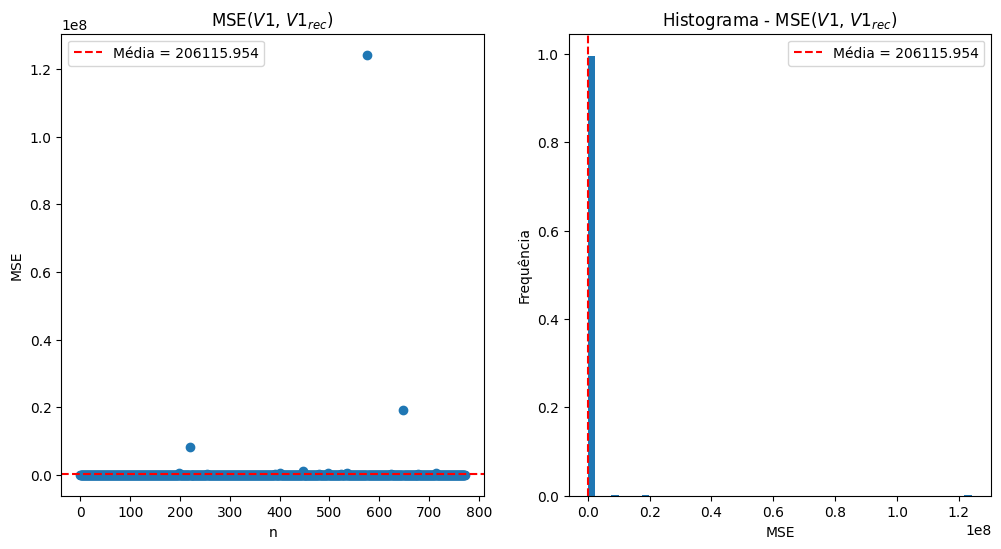

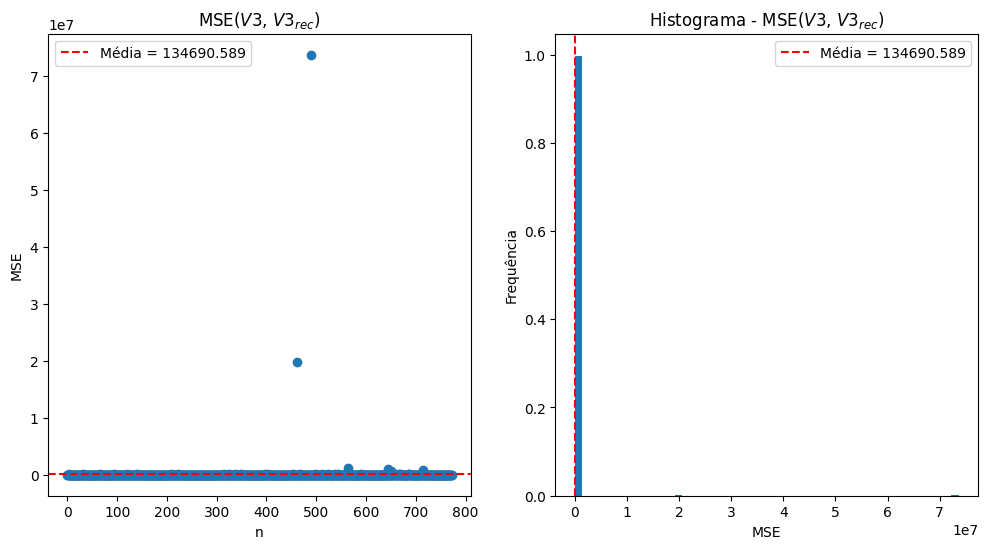

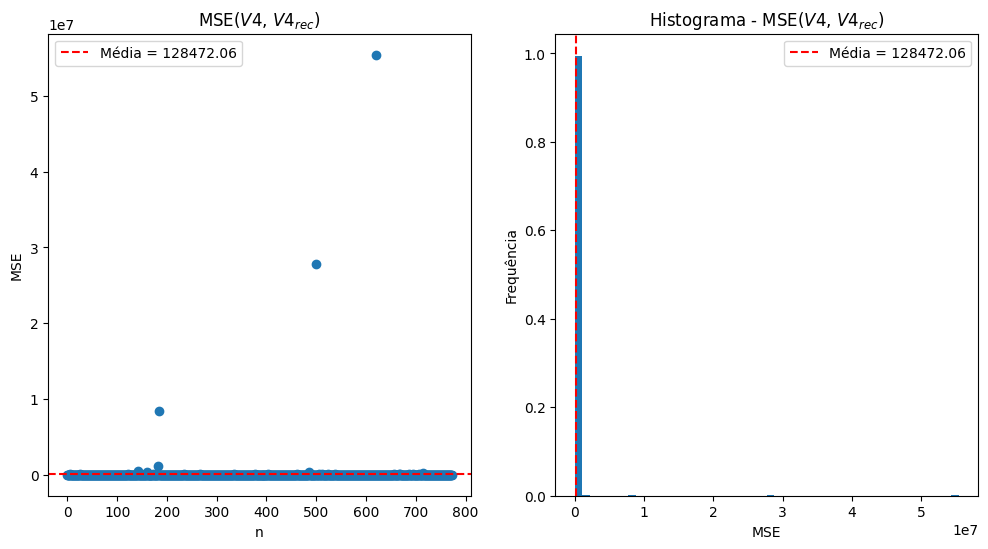

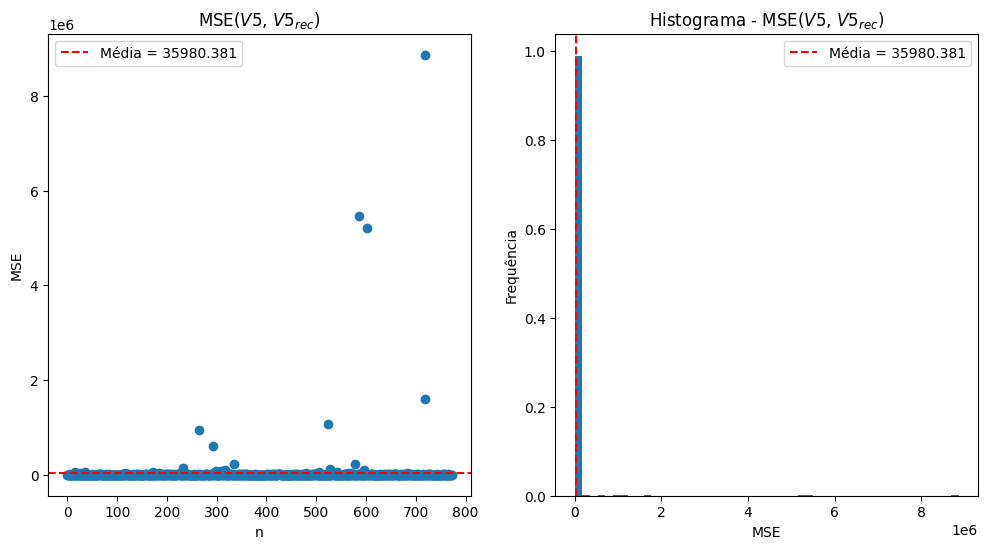

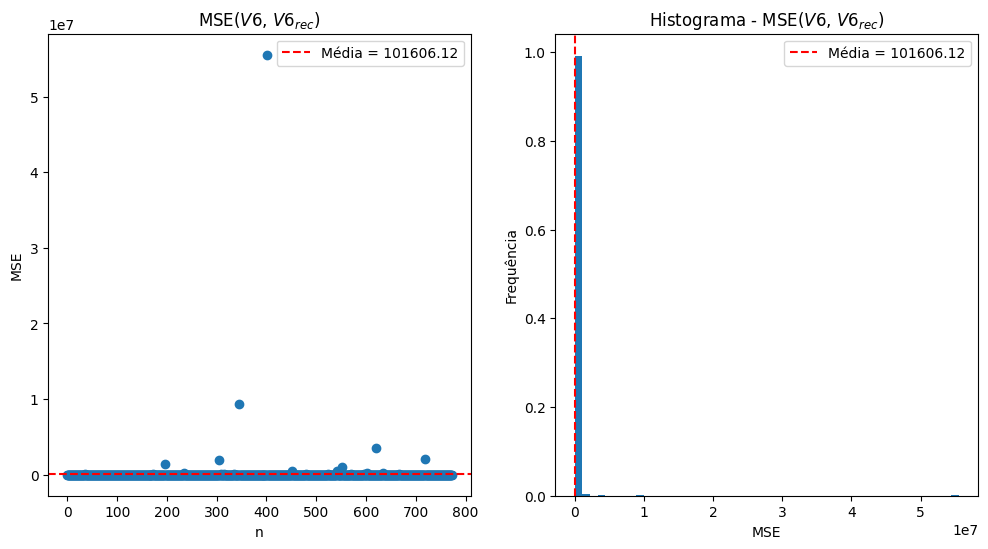

In [14]:
for derivation in ecgTarget:
	methodComparativePlot(mseScores, derivation, "MSE")

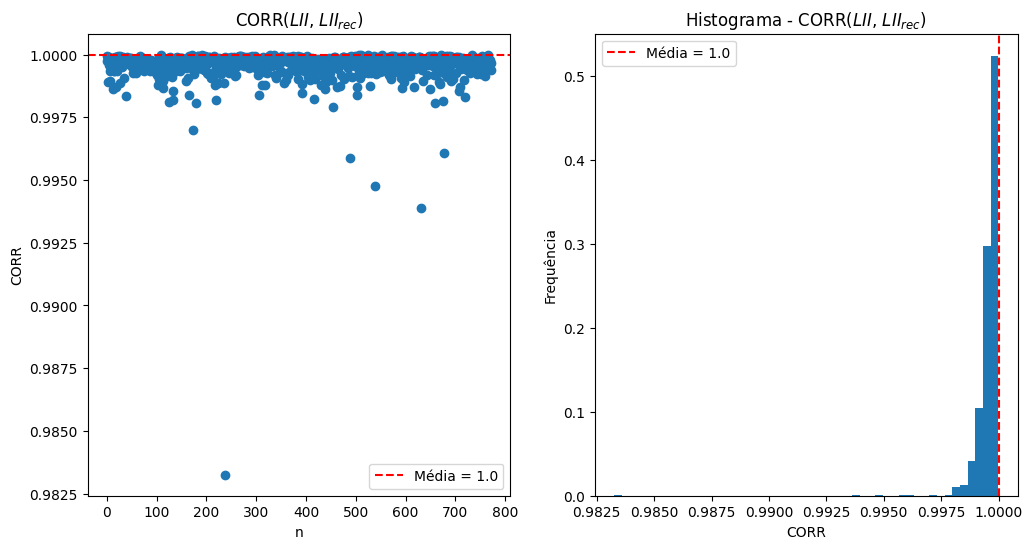

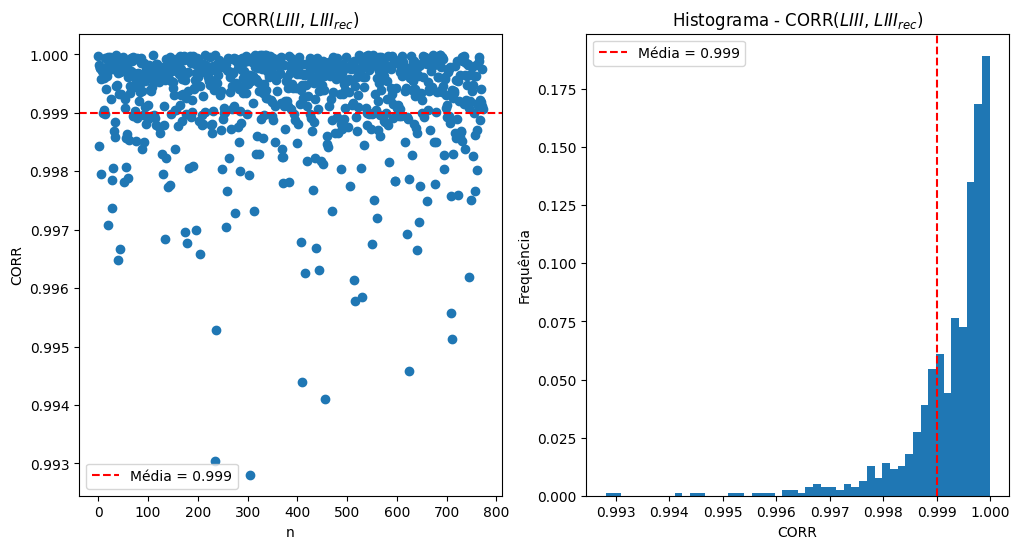

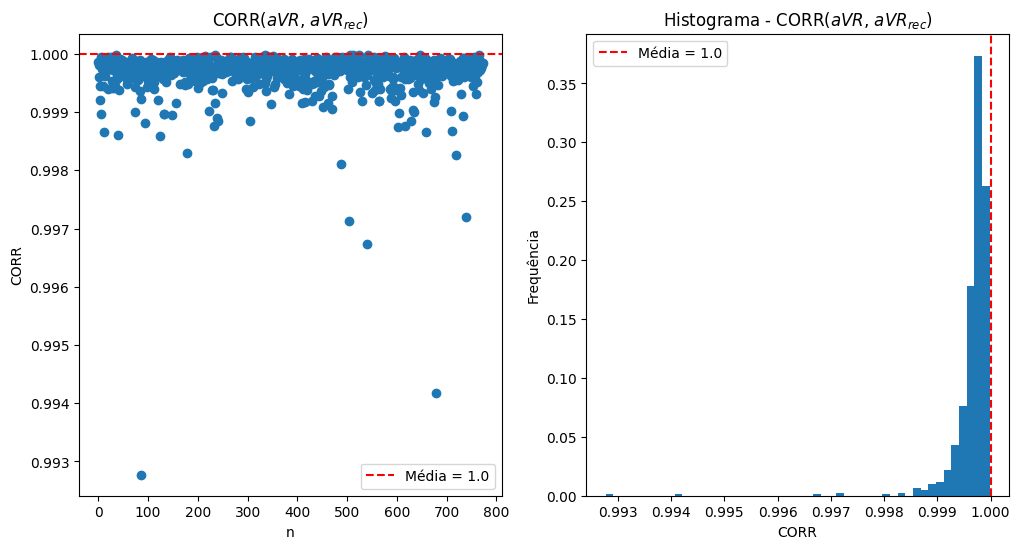

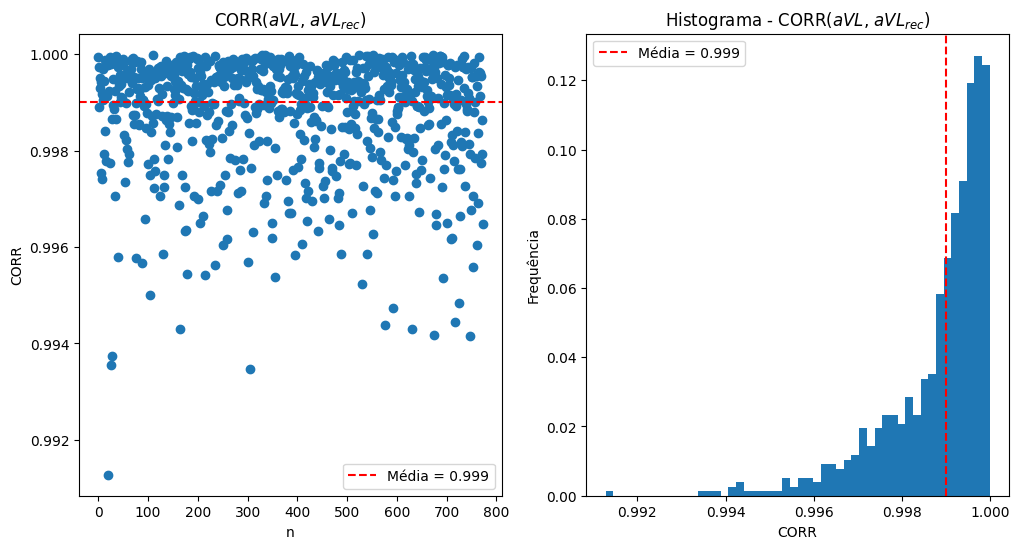

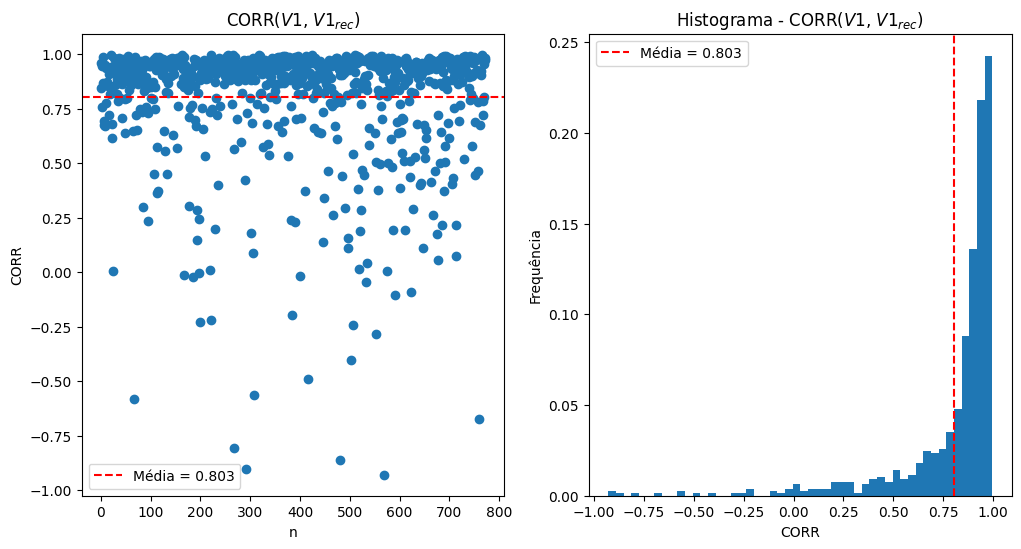

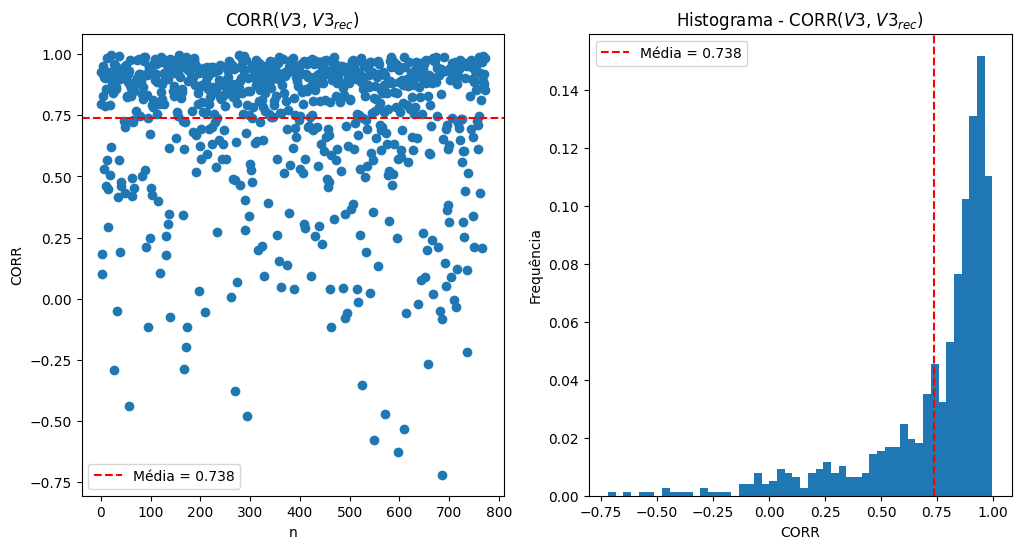

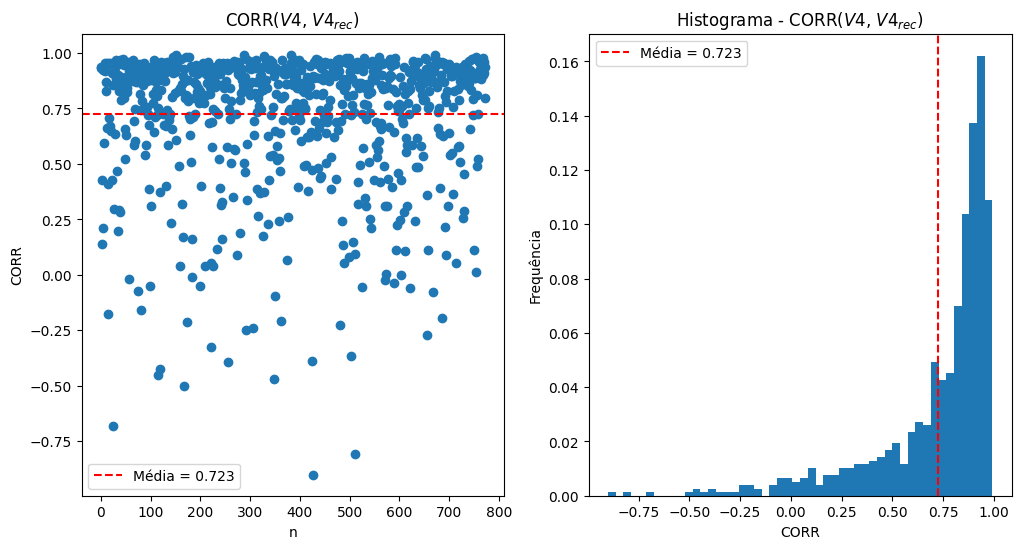

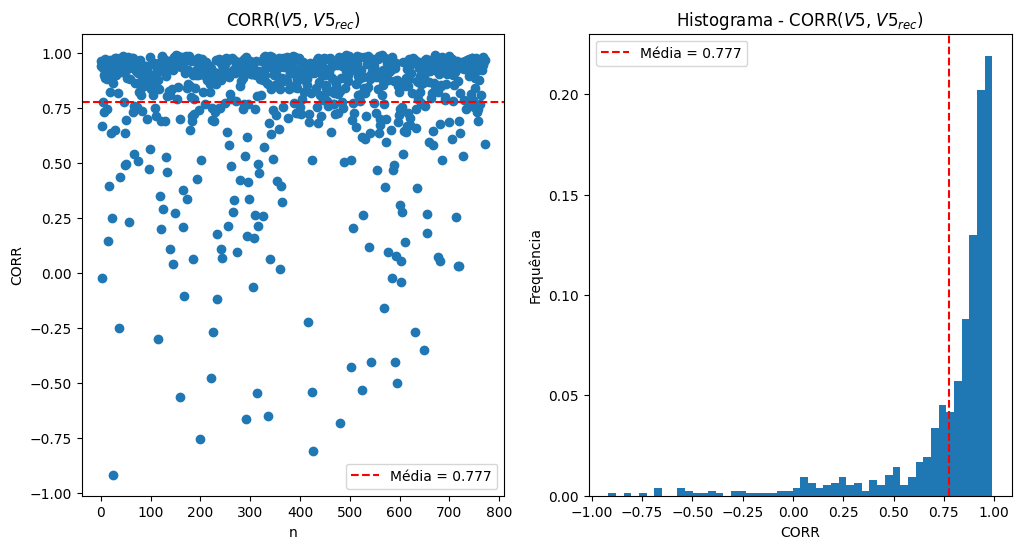

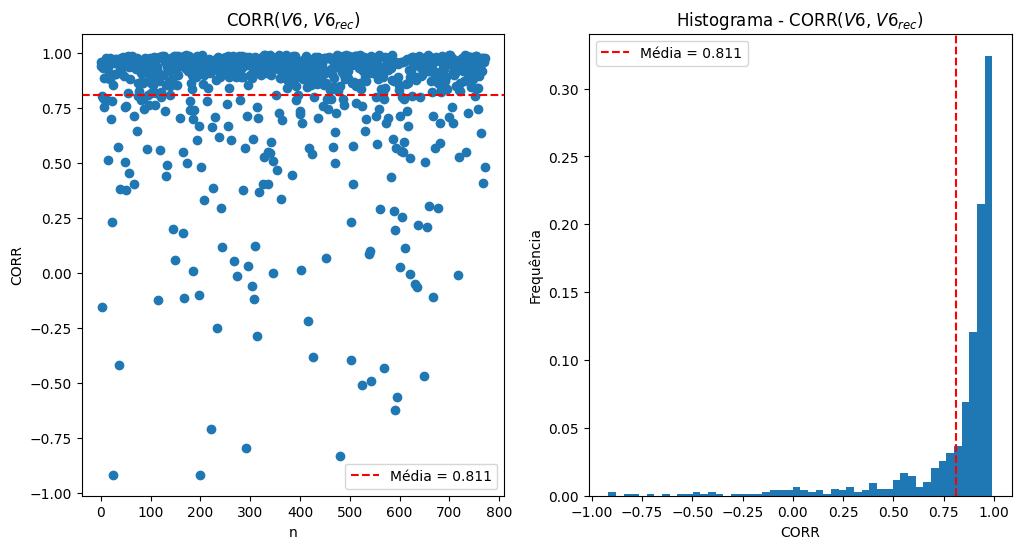

In [15]:
for derivation in ecgTarget:
	methodComparativePlot(correlations, derivation, "CORR")